<a href="https://colab.research.google.com/github/AbdulmagedALKHULAIFI/Automatic-classifer-consumer-goods/blob/main/p6_2_IMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pip install --upgrade pip

In [3]:
# pip install --upgrade Pillow

In [4]:
pip install opencv-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 47.8 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
 pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 65.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


#Import

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
from os import listdir
from matplotlib.image import imread
import random
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import seaborn as sns

In [7]:
#Variable globales
imgs_path = "/content/drive/MyDrive/OC/Projet 6/data/Images/"
preprocessed_imgs_path = '/content/drive/MyDrive/OC/Projet 6/data/preprocessed_images/'
list_photos = [file for file in listdir(imgs_path)]
print(len(list_photos))

1050


# Analyses exploratoires

In [8]:
data = pd.read_csv("/content/drive/MyDrive/OC/Projet 6/flipkart_com-ecommerce_sample_1050.csv")
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


#Nettoyage et préparation des données

In [9]:
data = data[['image',"product_category_tree"]].copy('deep')
data

,image,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1047,5912e037d12774bb73a2048f35a00009.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."


Nous allons maintenant nous interesser aux catégories principaux des produits.

In [10]:
data['main_category'] = data.product_category_tree.str.split(">>",expand=True,)[0]
data['main_category'] = data['main_category'].str.replace(r'"', '')
data['main_category'] = data['main_category'].str.replace(r'[', '')
data['main_category'] = data['main_category'].str.replace(r']', '')
data.head(3)

,image,product_category_tree,main_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care


In [11]:
data = data.drop(axis=1,columns = 'product_category_tree')
data.head(3)

,image,main_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care


Nous allons maintenant ajouté le chemin des images sur le drive. Vous pouvez le remplacer par l'addresse à votre convenance.

In [12]:
path = imgs_path
data['image'] = path + data['image'].astype(str)
data.head(3)

,image,main_category
0,/content/drive/MyDrive/OC/Projet 6/data/Images...,Home Furnishing
1,/content/drive/MyDrive/OC/Projet 6/data/Images...,Baby Care
2,/content/drive/MyDrive/OC/Projet 6/data/Images...,Baby Care


## Etiquetage des images

In [13]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["main_category"])
data

,image,main_category,label
0,/content/drive/MyDrive/OC/Projet 6/data/Images...,Home Furnishing,4
1,/content/drive/MyDrive/OC/Projet 6/data/Images...,Baby Care,0
2,/content/drive/MyDrive/OC/Projet 6/data/Images...,Baby Care,0
3,/content/drive/MyDrive/OC/Projet 6/data/Images...,Home Furnishing,4
4,/content/drive/MyDrive/OC/Projet 6/data/Images...,Home Furnishing,4
...,...,...,...
1045,/content/drive/MyDrive/OC/Projet 6/data/Images...,Baby Care,0
1046,/content/drive/MyDrive/OC/Projet 6/data/Images...,Baby Care,0
1047,/content/drive/MyDrive/OC/Projet 6/data/Images...,Baby Care,0
1048,/content/drive/MyDrive/OC/Projet 6/data/Images...,Baby Care,0


In [14]:
data.groupby("label").count()

,image,main_category
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


In [15]:
def list_images(name) :

    list_image_name = data[data['main_category']==name]
    return list_image_name.image.values

In [16]:
list_home_furnishing =list_images("Home Furnishing ")
list_baby_care=list_images("Baby Care ")
list_watches=list_images("Watches ")
list_home_decor_festive =list_images("Home Decor & Festive Needs ")
list_kitchen_dining =list_images("Kitchen & Dining ")
list_beauty_personal_care = list_images("Beauty and Personal Care ")
list_computers = list_images("Computers ")

## Affichage d'exemples des images par catégorie

Home furnishing
-------


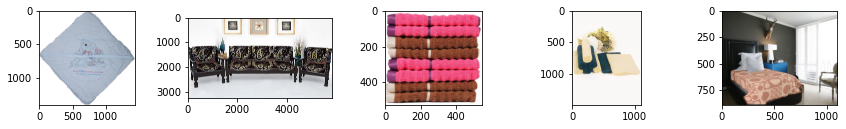

Baby care 
-------


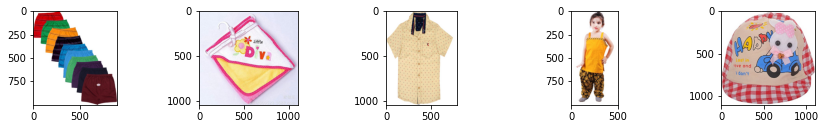

Watch
-------


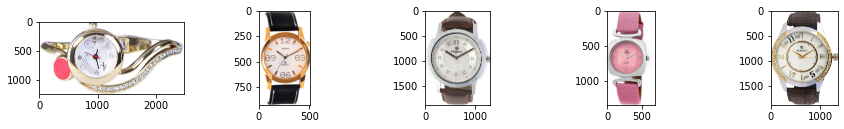

Home decoration and festivals
-------


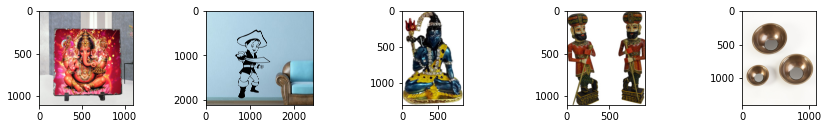

Kichen dinning
-------


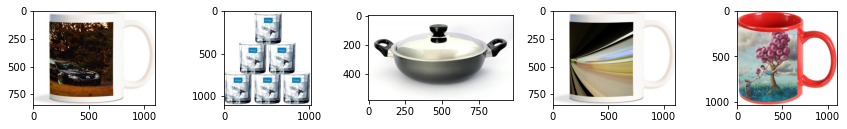

Beauty and personal care 
-------


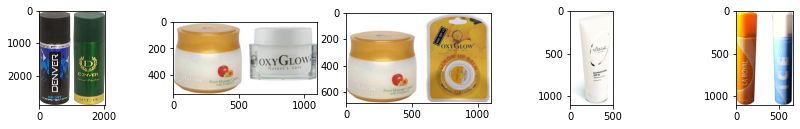

Computer
-------


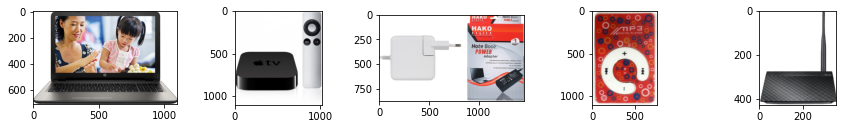

In [25]:

# creating a new dictionary
labels_dictionary ={
    "Home furnishing": list_home_furnishing ,
    "Baby care " : list_baby_care,
    "Watch" : list_watches,
    "Home decoration and festivals" : list_home_decor_festive ,
    "Kichen dinning" : list_kitchen_dining ,
    "Beauty and personal care " : list_beauty_personal_care ,
    "Computer" : list_computers}
 
# list out keys and values separately
key_list = list(labels_dictionary.keys())
val_list = list(labels_dictionary.values())

# print(key_list[0])

category_name_indice = 0

for category in val_list :

    print(key_list[category_name_indice])
    max_number_images_categories = len(category)-1
    print("-------")
    for i in range(5):
        plt.subplot(5,5,i+1)
        random_photo = random.randint(1, max_number_images_categories)
        filename = category.item(random_photo)
        image = imread(filename)
        plt.imshow(image)

    category_name_indice = category_name_indice + 1
    plt.gcf().set_size_inches(15, 10)
    plt.show()

In [ ]:
def resize_image(img, size, interpolation):
    """Function to resize image without deformation."""
    
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    
    if h == w: return cv2.resize(img, (size, size), interpolation)
    if h > w: dif = h 
    else:     dif = w
        
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    
    if c is None:
        # mask = np.zeros((dif, dif), dtype=img.dtype)
        mask = np.full((dif, dif), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        
    else:
        # mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask = np.full((dif, dif, c), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
        
    return cv2.resize(mask, (size, size), interpolation)

In [ ]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)


In [ ]:
dir_read = imgs_path
dir_write = preprocessed_imgs_path

def preprocess_images():

  # for each product in the data
  for index, row in df_pict.iterrows():
      
      # get url of the product's image
      img_name = row['image']
      
      # create the path to the image file
      img_path = dir_read+img_name
      
      # Read the file and convert it to color image
      img_file = cv2.imread(img_path)
      img_rgb = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)
      
      # resize the image to 224*224 pixels
      img_sqr = resize_image(img_rgb, size=224, interpolation=cv2.INTER_AREA)
      
      # auto-adjustment of contrast and luminosity
      img_preprocessed, alpha, beta = automatic_brightness_and_contrast(img_sqr)
      
      # save the preprocessed image
      img_preprocessed_path = dir_write+img_name
      cv2.imwrite(img_preprocessed_path, img_preprocessed)

# Pré-traitement des images

### ORB

### Pré-traitement des images via SIFT

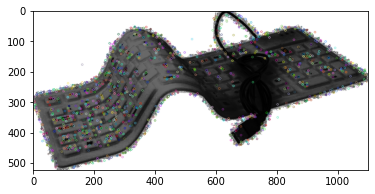

Descripteurs :  (1464, 128)

[[  1.  16. 117. ...   0.  22.  76.]
 [  0.   0.  11. ...  12.   1.   1.]
 [  5.  20.  20. ...   0.   0.  10.]
 ...
 [ 83.  68.  10. ...   0.   0.   8.]
 [  0.   0.   0. ...   3.   8.  15.]
 [ 10.   1.   1. ...   0.   0.   4.]]


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


*   L'image contient 1464 descripteurs
*   Chaque descripteur est un vecteur de longueur 128



#### Création de descriptions de chaque image

*   Pour chaque image passage en gris et equalisation
*   création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
*   création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs


In [ ]:
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517267, 128)
temps de traitement SIFT descriptor :           509.96 secondes


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# Segementation des descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [ ]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :           131.33 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster.

In [ ]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            15.79 secondes


## Réductions de dimension


### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 504)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["main_category"]
print(df_tsne.shape)

(1050, 3)


In [ ]:
df_tsne.head(3)

,tsne1,tsne2,class
0,-6.643316,22.851845,Home Furnishing
1,15.177532,-22.107071,Baby Care
2,16.180252,-9.048715,Baby Care


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

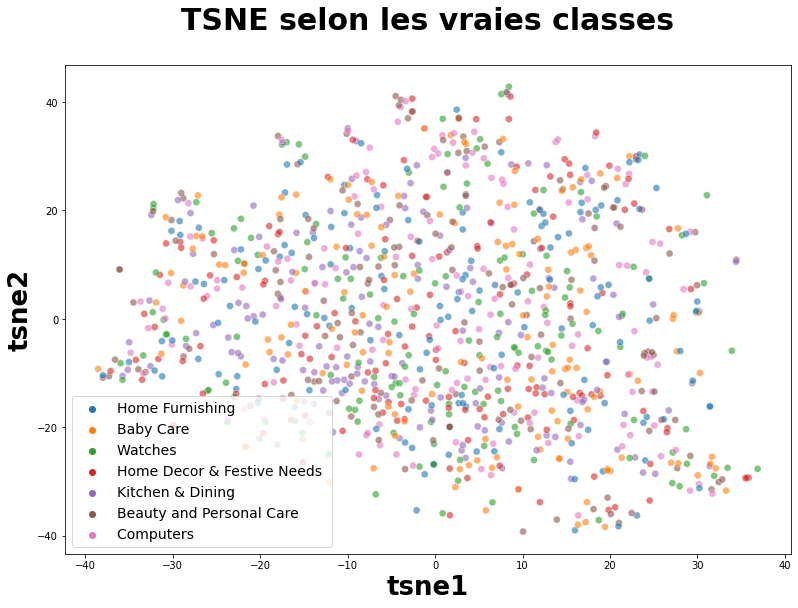

In [ ]:
plt.figure(figsize=(13,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [ ]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

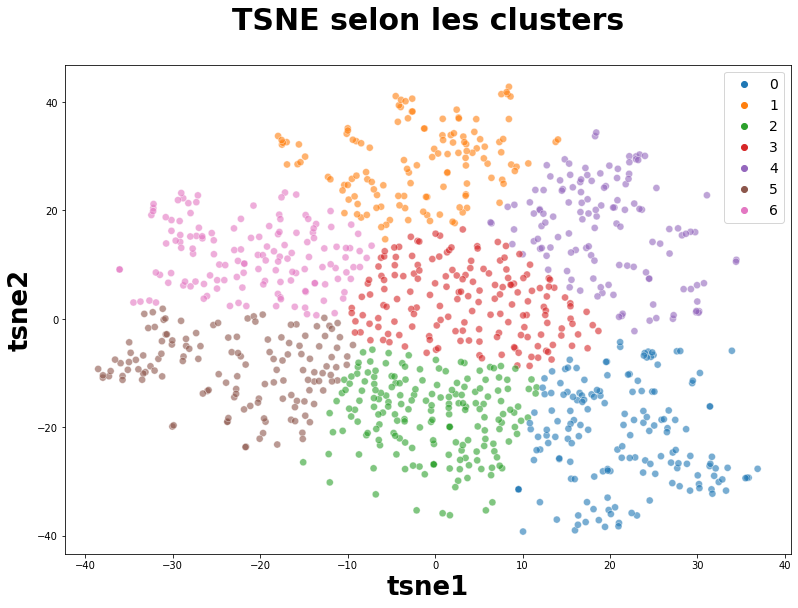

ARI :  0.003183466522860957


In [ ]:
plt.figure(figsize=(13,9))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Evaluation

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [ ]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    163
1    129
2    183
3    165
4    131
5    137
6    142
Name: class, dtype: int64

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[36 17 22 19 20 15 21]
 [24 25 20 24 19 17 21]
 [22 29 23 24 17 14 21]
 [22 14 32 25 18 24 15]
 [22 12 20 27 28 19 22]
 [22 16 30 16 13 29 24]
 [15 16 36 30 16 19 18]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    # corresp = [0, 6,  1, 3, 4, 5,2]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

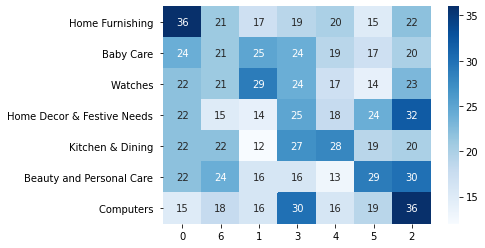

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
df_cm = df_cm.reindex(['0','6',  '1', '3', '4', '5','2'], axis="columns")
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
print(metrics.classification_report(labels, cls.labels_))

              precision    recall  f1-score   support

           0       0.22      0.24      0.23       150
           1       0.19      0.17      0.18       150
           2       0.13      0.15      0.14       150
           3       0.15      0.17      0.16       150
           4       0.21      0.19      0.20       150
           5       0.21      0.19      0.20       150
           6       0.13      0.12      0.12       150

    accuracy                           0.18      1050
   macro avg       0.18      0.18      0.18      1050
weighted avg       0.18      0.18      0.18      1050



# Test